# Import 

In [3]:
from gemseo_oad_training.models import aerodynamic
from gemseo_oad_training.models import approach
from gemseo_oad_training.models import battery
from gemseo_oad_training.models import climb
from gemseo_oad_training.models import engine
from gemseo_oad_training.models import fuel_tank
from gemseo_oad_training.models import geometry
from gemseo_oad_training.models import mass
from gemseo_oad_training.models import mission
from gemseo_oad_training.models import operating_cost
from gemseo_oad_training.models import take_off
from gemseo_oad_training.models import total_mass
from gemseo import configure_logger
from gemseo.disciplines.auto_py import AutoPyDiscipline
from matplotlib import pyplot as plt
from gemseo import sample_disciplines
from gemseo.algos.parameter_space import ParameterSpace
import pprint
from gemseo.algos.parameter_space import ParameterSpace
from gemseo import to_pickle
from gemseo.disciplines.surrogate import SurrogateDiscipline
from lh2pac.utils import update_default_inputs
from gemseo import to_pickle
import pandas as pd

configure_logger()

<RootLogger root (INFO)>

# Instanciate disciplines

In [4]:
# On veut résoudre le problème 1 avec UC1 et UC2
disciplines = [AutoPyDiscipline(aerodynamic), AutoPyDiscipline(approach), AutoPyDiscipline(battery), AutoPyDiscipline(climb), AutoPyDiscipline(engine), AutoPyDiscipline(fuel_tank), AutoPyDiscipline(geometry), AutoPyDiscipline(mass), AutoPyDiscipline(mission), AutoPyDiscipline(operating_cost), AutoPyDiscipline(take_off), AutoPyDiscipline(total_mass)]

# Fix optimal parameters

In [5]:
update_default_inputs(disciplines, {"slst": 103361.02397518, "n_pax":120, "area":103.45450184, "ar":15.16956933, "fuel_type":"liquid_h2"})
disciplines[0].io.input_grammar.defaults

{'area': 103.45450184, 'ar': 15.16956933, 'length': 37.0, 'aef': 1.0}

# Create uncertain space

In [6]:
uncertain_space = ParameterSpace()
uncertain_space.add_random_variable("aef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("cef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("sef", "OTTriangularDistribution", minimum=0.99, mode=1, maximum=1.03)
uncertain_space.add_random_variable("gi", "OTTriangularDistribution", minimum=0.35, mode=0.4, maximum=0.405)
uncertain_space.add_random_variable("vi", "OTTriangularDistribution", minimum=0.755, mode=0.800, maximum=0.805)

# Split train/test dataset

In [7]:
training_dataset = sample_disciplines(disciplines, uncertain_space, ["mtom","tofl", "vapp", "vz", "span", "length", "fm"], algo_name="OT_OPT_LHS", n_samples=20)
test_dataset = sample_disciplines(disciplines, uncertain_space, ["mtom","tofl", "vapp", "vz", "span", "length", "fm"], algo_name="OT_MONTE_CARLO", n_samples=20)

    INFO - 17:39:02: *** Start Sampling execution ***
    INFO - 17:39:02: Sampling
    INFO - 17:39:02:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 17:39:02:    MDO formulation: MDF
    INFO - 17:39:02: Running the algorithm OT_OPT_LHS:
    INFO - 17:39:02:    100%|██████████| 20/20 [00:00<00:00, 210.74 it/sec]
    INFO - 17:39:02: *** End Sampling execution (time: 0:00:00.105733) ***
    INFO - 17:39:02: *** Start Sampling execution ***
    INFO - 17:39:02: Sampling
    INFO - 17:39:02:    Disciplines: aerodynamic approach battery climb engine fuel_tank geometry mass mission operating_cost take_off total_mass
    INFO - 17:39:02:    MDO formulation: MDF
    INFO - 17:39:02: Running the algorithm OT_MONTE_CARLO:
    INFO - 17:39:02:    100%|██████████| 20/20 [00:00<00:00, 274.54 it/sec]
    INFO - 17:39:02: *** End Sampling execution (time: 0:00:00.076612) ***


# Try different surrogate

 Testing surrogate: RBF_gaussian
 Testing surrogate: RBF_gaussian_mg
 Testing surrogate: Polynomial_deg2
 Testing surrogate: Polynomial_deg2

Résultats comparatifs :
                     fm  length    mtom  span    tofl    vapp      vz
Model                                                                
RBF_gaussian     0.8985     1.0  0.8302   1.0  0.8298  0.8384  0.8729
RBF_gaussian_mg  0.9933     1.0  0.9921   1.0  0.9920  0.9924  0.9950
Polynomial_deg2  0.9995     1.0  0.9887   1.0  0.9886  0.9885  0.9867
Polynomial_deg2  0.9581     1.0  0.9711   1.0  0.9709  0.9709  0.9660


<Figure size 1200x600 with 0 Axes>

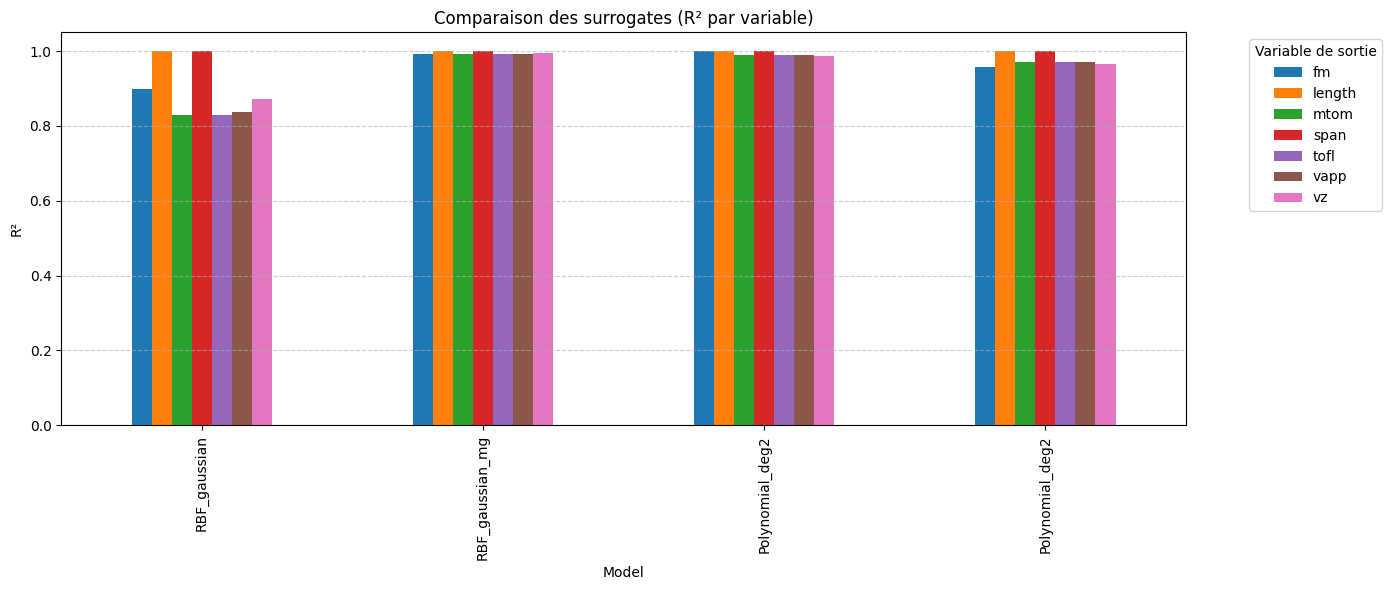

In [8]:
surrogate_configs = [
    {"name": "RBF_gaussian", "model": "RBFRegressor", "function": "gaussian"},
    {"name": "RBF_gaussian_mg", "model": "RBFRegressor", "function": "multiquadric"},
    {"name": "Polynomial_deg2", "model": "PolynomialRegressor", "degree": 2},
    {"name": "Polynomial_deg2", "model": "PolynomialRegressor", "degree": 3},
]

results = []

for config in surrogate_configs:
    name = config["name"]
    model_type = config["model"]
    kwargs = {k: v for k, v in config.items() if k not in ["name", "model"]}

    print(f" Testing surrogate: {name}")
    
    surrogate = SurrogateDiscipline(model_type, data=training_dataset, **kwargs)
    r2 = surrogate.get_error_measure("R2Measure")
    test_scores = r2.compute_test_measure(test_dataset, as_dict=True)
    
    flat_scores = {key: float(value) for key, value in test_scores.items()}
    flat_scores["Model"] = name
    results.append(flat_scores)

df_results = pd.DataFrame(results)
df_results = df_results.set_index("Model")
print("\nRésultats comparatifs :")
print(df_results.round(4)
)
plt.figure(figsize=(12, 6))
df_results.plot(kind="bar", figsize=(14, 6))
plt.title("Comparaison des surrogates (R² par variable)")
plt.ylabel("R²")
plt.ylim(0, 1.05)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.legend(title="Variable de sortie", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Save best surrogate

In [12]:
surrogate_discipline = SurrogateDiscipline("RBFRegressor",data = training_dataset, function= "multiquadric")

In [13]:
r2.compute_test_measure(test_dataset, as_dict=True)

{'fm': array([0.95808391]),
 'length': array([1.]),
 'mtom': array([0.97108304]),
 'span': array([1.]),
 'tofl': array([0.97088264]),
 'vapp': array([0.97091014]),
 'vz': array([0.96604689])}

In [14]:
rmse = surrogate_discipline.get_error_measure("RMSEMeasure")
rmse.compute_test_measure(test_dataset, as_dict=True)

{'fm': array([0.00148746]),
 'length': array([0.]),
 'mtom': array([47.25582373]),
 'span': array([0.]),
 'tofl': array([2.8257121]),
 'vapp': array([0.02623419]),
 'vz': array([0.01036981])}

In [15]:
to_pickle(surrogate_discipline, "UC2_my_surrogate_2.pkl")